<a href="https://colab.research.google.com/github/yohancsx/SmartMask/blob/main/micro_ml/BLE_Sense_SVM_Train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!apt-get -qq install xxd
!pip install pandas numpy matplotlib
!pip install scikit-learn
!pip install micromlgen


Selecting previously unselected package xxd.
(Reading database ... 146364 files and directories currently installed.)
Preparing to unpack .../xxd_2%3a8.0.1453-1ubuntu1.4_amd64.deb ...
Unpacking xxd (2:8.0.1453-1ubuntu1.4) ...
Setting up xxd (2:8.0.1453-1ubuntu1.4) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
  Created wheel for micromlgen: filename=micromlgen-1.1.21-cp36-none-any.whl size=25967 sha256=1d067b8cf631c4bfa0b856595e7759c51fd6ca28b9435cd57ce281e819741247
  Stored in directory: /root/.cache/pip/wheels/20/55/0d/f8bae1fcd442426217dd7b877a1859de9b17f811f21118cbdb
Successfully built micromlgen


In [16]:
#imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from micromlgen import port
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm

In [4]:
#load all the data into seperate dataframes

#the name for the breathing data
breathingFile = "regular_breathing.csv"

#the name for the coughing data
coughingFile = "coughing.csv"

#the filename for the talking data
talkingFile = "talking.csv"

#the filename for the deep breathing data
deepBreathingFile = "deep_breathing.csv"

#the filename for the combined data
combinedFile = "mixed.csv"

#plot some of the data on the same axes
dfTalk = (pd.read_csv("/content/" + talkingFile, index_col=False, header=None, names = ["pressure"])).dropna(axis = 1)
dfBreathe = (pd.read_csv("/content/" + breathingFile, index_col=False, header=None, names = ["pressure"])).dropna(axis = 1)
dfCough = (pd.read_csv("/content/" + coughingFile, index_col=False, header=None, names = ["pressure"])).dropna(axis = 1)
dfDeepBreathe = (pd.read_csv("/content/" + deepBreathingFile, index_col=False, header=None, names = ["pressure"])).dropna(axis = 1)
dfMixed = (pd.read_csv("/content/" + talkingFile, index_col=False, header=None, names = ["pressure"])).dropna(axis = 1)

display("done loading data")

'done loading data'

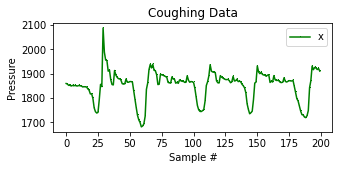

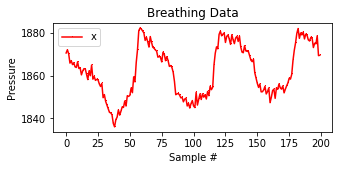

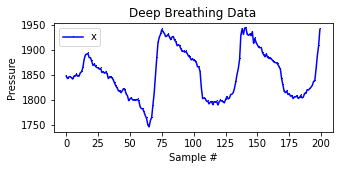

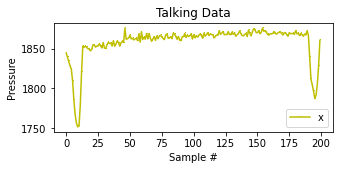

In [5]:
#plot some of the sample data
plt.rcParams["figure.figsize"] = (5,2)

#the indices
index = range(0, 200)

plt.plot(index, dfCough.head(200), 'g.', label='x', linestyle='solid', marker=',')
plt.title("Coughing Data")
plt.xlabel("Sample #")
plt.ylabel("Pressure")
plt.legend()
plt.show()

plt.plot(index, dfBreathe.head(200), 'r.', label='x', linestyle='solid', marker=',')
plt.title("Breathing Data")
plt.xlabel("Sample #")
plt.ylabel("Pressure")
plt.legend()
plt.show()

plt.plot(index, dfDeepBreathe.head(200), 'b.', label='x', linestyle='solid', marker=',')
plt.title("Deep Breathing Data")
plt.xlabel("Sample #")
plt.ylabel("Pressure")
plt.legend()
plt.show()

plt.plot(index, dfTalk.head(200), 'y.', label='x', linestyle='solid', marker=',')
plt.title("Talking Data")
plt.xlabel("Sample #")
plt.ylabel("Pressure")
plt.legend()
plt.show()



In [23]:
#prepare the datasets

#set the random seed
SEED = 1337
np.random.seed(SEED)

#the list of breathing types to classify
BREATHING_TYPES = [
    "coughing",
    "breathing",
    "deepBreathing",
    "talking"
]

#the classmap of breathing types (needed for exporting to arduino)
BREATHING_TYPE_MAP = {
     0:"coughing",
    1:"breathing",
    2:"deepBreathing",
    3:"talking"
}

#the list of dataframes of the breathing types
BREATHING_DATA_LIST = [dfCough,dfBreathe,dfDeepBreathe,dfTalk]

#the raw number of samples per period
SAMPLES_PER_PERIOD = 200

NUM_TYPES = len(BREATHING_TYPES)

#create a one-hot encoded matrix that is used in the output
ONE_HOT_ENCODED_TYPES = np.eye(NUM_TYPES)


#input and putput files
inputs = []
outputs = []
outputs_str = []

#set to a number far greater than the maximum number of samples (or infinity)
minsamples = np.inf

#the maximum pressure value so data is between 0 and 1
maxpressure = 3000

#find the min number of samples, also the max value
for type_index in range(NUM_TYPES):
  #get the type data
  type_data = BREATHING_DATA_LIST[type_index]
  if((type_data.shape[0] - SAMPLES_PER_PERIOD/2) < minsamples):
    minsamples = type_data.shape[0] - SAMPLES_PER_PERIOD/2
  
display("minimum samples:")
display(minsamples)

'minimum samples:'

1072.0

In [24]:
#Option 1: split the dataset into overlapping portions
distance_between_samples = 20

for type_index in range(NUM_TYPES): 
  #get the type data
  type_data = BREATHING_DATA_LIST[type_index]
  #get the tensors with the samples, start by getting the first sampling period until the last
  for i in range(int(SAMPLES_PER_PERIOD/2),int(minsamples),int(distance_between_samples)):
    tensor = []
    output = ONE_HOT_ENCODED_TYPES[type_index]
    output_str = BREATHING_TYPES[type_index]
    for j in range(SAMPLES_PER_PERIOD):
      dataIndex = i + j - SAMPLES_PER_PERIOD/2
      tensor += [type_data['pressure'][dataIndex]/maxpressure]
  
    #append the data
    inputs.append(tensor)
    outputs.append(output)
    outputs_str.append(output_str)

inputs = np.array(inputs)
outputs = np.array(outputs)
outputs_str = np.array(outputs_str)

display("input shape:")
display(inputs.shape)

display("output shape:")
display(outputs.shape)


display("output strings shape:")
display(outputs_str.shape)

'input shape:'

(196, 200)

'output shape:'

(196, 4)

'output strings shape:'

(196,)

In [25]:
#randomize and split inputs and outputs into training and test sets
num_inputs = len(inputs)
randomize = np.arange(num_inputs)
np.random.shuffle(randomize)

#swap the consecutive indexes (0, 1, 2, etc) with the randomized indexes
inputs = inputs[randomize]
outputs = outputs[randomize]
outputs_str = outputs_str[randomize]


#split the recordings (group of samples) into two sets, training and testing
TRAIN_SPLIT = int(0.7 * num_inputs)


inputs_train, inputs_test = np.split(inputs, [TRAIN_SPLIT])
outputs_train, outputs_test = np.split(outputs, [TRAIN_SPLIT])
outputs_str_train, outputs_str_test = np.split(outputs_str, [TRAIN_SPLIT])

display("input train shape:")
display(inputs_train.shape)

display("output_train shape:")
display(outputs_train.shape)

display("output_str_train shape:")
display(outputs_str_train.shape)

display("input_test shape:")
display(inputs_test.shape)

display("output_test shape:")
display(outputs_test.shape)

display("output_str_test shape:")
display(outputs_str_test.shape)

'input train shape:'

(137, 200)

'output_train shape:'

(137, 4)

'output_str_train shape:'

(137,)

'input_test shape:'

(59, 200)

'output_test shape:'

(59, 4)

'output_str_test shape:'

(59,)

In [26]:
#train forest
random_forest = RandomForestClassifier(30, max_depth=15).fit(inputs_train, outputs_train)
display('done fitting')

'done fitting'

In [27]:
#train SVM
svm = svm.LinearSVC().fit(inputs_train, outputs_str_train)

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [29]:
#determine accuracies
display("accuracy of random forest: ")
display(random_forest.score(inputs_test,outputs_test))

display("accuracy of SVM: ")
display(svm.score(inputs_test,outputs_str_test))

'accuracy of random forest: '

0.7796610169491526

'accuracy of SVM: '

0.23728813559322035

In [30]:
#export
c_code = port(random_forest, classmap=BREATHING_TYPE_MAP)
print(c_code)

#pragma once
#include <cstdarg>
namespace Eloquent {
    namespace ML {
        namespace Port {
            class RandomForest {
                public:
                    /**
                    * Predict class for features vector
                    */
                    int predict(float *x) {
                        uint8_t votes[[2, 2, 2, 2]] = { 0 };
                        // tree #1
                        if (x[160] <= 0.6280352175235748) {
                            if (x[128] <= 0.6285718381404877) {
                                if (x[183] <= 0.6063880920410156) {
                                    votes[1] += 1;
                                }

                                else {
                                    if (x[139] <= 0.6248575747013092) {
                                        if (x[167] <= 0.625582367181778) {
                                            if (x[39] <= 0.6200726926326752) {
                                                if (x[162] <